# CES Accuracy Analysis - Figures

This notebook generates all figures and tables for the CES Accuracy Analysis results section.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy import stats
import seaborn as sns
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Ensure output directory exists
os.makedirs('output', exist_ok=True)

## Color Schemes

In [2]:
# =============================================================================
# COLOR SCHEME - Consistent, colorblind-friendly palette for scientific figures
# Based on Paul Tol's qualitative palette with modifications for print clarity
# =============================================================================

# Weighting method colors - Blue-to-warm progression
WEIGHTING_COLORS = {
    'CES-Unweighted': '#332288',         # Deep indigo
    'CES-Provided Weights': '#6699CC',   # Steel blue  
    'ANESRake-Full': '#CC6677',          # Dusty rose
    'ANESRake-Restricted': '#882255'     # Deep burgundy
}

# Variable class colors - Distinct, accessible palette
CLASS_COLORS = {
    'Demographic': '#4477AA',            # Muted blue
    'Voting Administration': '#EE6677',  # Soft coral
    'Candidate Choice': '#228833'        # Forest green
}

# Variable type colors - Clear contrast pair
VARIABLE_TYPE_COLORS = {
    'Primary': '#BBBBBB',                # Medium gray
    'Secondary': '#4477AA'               # Muted blue (matches demographic)
}

# Specificity colors
SPECIFICITY_COLORS = {
    'Candidate': '#228833',              # Forest green
    'Party': '#CCBB44'                   # Olive gold
}

# Legend labels
WEIGHTING_LABELS = {
    'CES-Unweighted': 'Unweighted',
    'CES-Provided Weights': 'CES Weighted',
    'ANESRake-Full': 'Calibration-Weighted (Full)',
    'ANESRake-Restricted': 'Calibration-Weighted (Restricted)'
}

# Print color scheme for reference
print("Color scheme loaded:")
print(f"  Classes: {list(CLASS_COLORS.keys())}")
print(f"  Types: {list(VARIABLE_TYPE_COLORS.keys())}")
print(f"  Weighting: {list(WEIGHTING_COLORS.keys())}")

Color scheme loaded:
  Classes: ['Demographic', 'Voting Administration', 'Candidate Choice']
  Types: ['Primary', 'Secondary']
  Weighting: ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full', 'ANESRake-Restricted']


## Load Data

In [3]:
# Load input tables
# most_specific: contains the most specific level for each observation (candidate when available, party otherwise)
# metrics_base_full: contains ALL data including both party and candidate level for same races

most_specific = pd.read_excel('input_tables/most_specific.xlsx')
metrics_base_full = pd.read_excel('input_tables/metrics_base.xlsx')

print("Data loaded successfully!")
print(f"most_specific: {most_specific.shape}")
print(f"metrics_base_full: {metrics_base_full.shape}")
print()
print("Columns in most_specific:")
print(most_specific.columns.tolist())
print()
print("Unique Weighting_Method values:")
print(most_specific['Weighting_Method'].unique())
print()
print("Unique Validity_Scheme values:")
print(most_specific['Validity_Scheme'].unique())

Data loaded successfully!
most_specific: (77082, 24)
metrics_base_full: (86568, 24)

Columns in most_specific:
['Year', 'State', 'Class', 'Variable', 'District', 'Category', 'Variable_Type', 'Used_in_ANESRake_Full', 'Used_in_ANESRake_Restricted', 'Valid_for_Accuracy_Full', 'Valid_for_Accuracy_Restricted', 'CES_Candidate', 'True_Candidate', 'Match_Score', 'Benchmark', 'CES_Unweighted', 'CES_Weighted', 'CES_ANESRake_Full', 'CES_ANESRake_Restricted', 'n_respondents', 'Specificity', 'Weighting_Method', 'Error', 'Validity_Scheme']

Unique Weighting_Method values:
['CES-Unweighted' 'CES-Provided Weights' 'ANESRake-Full'
 'ANESRake-Restricted']

Unique Validity_Scheme values:
['All' 'ANESRake - Full' 'ANESRake - Restricted']


## Helper Functions

In [4]:
def calculate_rmse(errors):
    """Calculate RMSE from a series of errors."""
    return np.sqrt(np.mean(errors**2))

def style_axis(ax, title=None, xlabel='', ylabel='RMSE (%)', ylim=None):
    """Apply consistent styling to an axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if ylim:
        ax.set_ylim(ylim)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)
    return ax

def save_figure(fig, filename, tight=True):
    """Save figure to output directory."""
    if tight:
        fig.tight_layout(pad=2.0)
    fig.savefig(f'output/{filename}', dpi=300, bbox_inches='tight')
    print(f"Saved: output/{filename}")


# Define sensible variable ordering
VARIABLE_ORDER = {
    'Age Group': 1, 'Education': 2, 'Sex': 3, 'Hispanic Origin': 4,
    'Employment Status': 5, 'Family Income': 6, 'Union Membership': 7,
    'Veteran Status': 8, 'Residence Duration': 9, 'State of Residence': 10,
    'Voter Registration': 20, 'Voting Turnout': 21, 'Voting Method': 22,
    'President': 30, 'U.S. Senate': 31, 'U.S. House': 32, 'Governor': 33,
    'Attorney General': 34, 'Secretary of State': 35, 'State Senator': 36,
    'State Representative': 37
}

# Map variables to their class
VARIABLE_CLASS = {
    'Age Group': 'Demographic', 'Education': 'Demographic', 'Sex': 'Demographic',
    'Hispanic Origin': 'Demographic', 'Employment Status': 'Demographic',
    'Family Income': 'Demographic', 'Union Membership': 'Demographic',
    'Veteran Status': 'Demographic', 'Residence Duration': 'Demographic',
    'State of Residence': 'Demographic',
    'Voter Registration': 'Voting Administration', 'Voting Turnout': 'Voting Administration',
    'Voting Method': 'Voting Administration',
    'President': 'Candidate Choice', 'U.S. Senate': 'Candidate Choice',
    'U.S. House': 'Candidate Choice', 'Governor': 'Candidate Choice',
    'Attorney General': 'Candidate Choice', 'Secretary of State': 'Candidate Choice',
    'State Senator': 'Candidate Choice', 'State Representative': 'Candidate Choice'
}

def sort_variables(df, var_col='Variable'):
    """Sort DataFrame by sensible variable ordering."""
    df = df.copy()
    df['_sort_order'] = df[var_col].map(VARIABLE_ORDER)
    df['_sort_order'] = df['_sort_order'].fillna(999)
    df = df.sort_values('_sort_order').drop(columns=['_sort_order'])
    return df

def get_variable_class(var_name):
    """Get the class for a variable."""
    return VARIABLE_CLASS.get(var_name, 'Unknown')

def save_latex(latex_str, filename):
    """Save LaTeX string to file."""
    with open(f'output/{filename}', 'w') as f:
        f.write(latex_str)
    print(f"Saved: output/{filename}")

---
# Figure 1: RMSE by Variable and Year (CES-Provided Weights)

Two versions:
- Version A: All variables with class labels and within-class averages
- Version B: Primary and Secondary sections with Class labels and averages

In [5]:
# Filter for CES-Provided Weights, Validity_Scheme All
df_ces_weighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_by_var_year = df_ces_weighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type (Primary/Secondary) for each cell
type_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

# Class for each variable
class_map = rmse_by_var_year.groupby('Variable')['Class'].first().to_dict()

# Sort by variable ordering
rmse_pivot = sort_variables(rmse_pivot.reset_index()).set_index('Variable')
type_pivot = sort_variables(type_pivot.reset_index()).set_index('Variable')

years = sorted([c for c in rmse_pivot.columns if isinstance(c, (int, float))])

# Add Average column
rmse_pivot['Average'] = rmse_pivot[years].mean(axis=1)

# Add Average row at BOTTOM
avg_row = rmse_pivot.mean(axis=0)
avg_row.name = 'Average'
rmse_pivot_with_avg = pd.concat([rmse_pivot, avg_row.to_frame().T])

print("="*100)
print("FIGURE 1: RMSE by Variable and Year (CES-Provided Weights)")
print("="*100)

FIGURE 1: RMSE by Variable and Year (CES-Provided Weights)


In [6]:
# ============================================================
# VERSION A: All variables with class subtotals
# ============================================================
print("\n" + "="*80)
print("VERSION A: All variables with class labels and within-class averages")
print("="*80)

# Calculate within-class averages
class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
class_values_a = {cls: {year: [] for year in years} for cls in class_order}
class_row_avgs_a = {cls: [] for cls in class_order}

for var in rmse_pivot.index:
    var_class = class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years:
        val = rmse_pivot.loc[var, year]
        if not pd.isna(val):
            class_values_a[var_class][year].append(val)
    row_avg = rmse_pivot_with_avg.loc[var, 'Average']
    if not pd.isna(row_avg):
        class_row_avgs_a[var_class].append(row_avg)

class_subtotals_a = {}
for cls in class_order:
    class_subtotals_a[cls] = {}
    for year in years:
        vals = class_values_a[cls][year]
        class_subtotals_a[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_a[cls][y] for y in years if not pd.isna(class_subtotals_a[cls][y])]
    class_subtotals_a[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Build LaTeX for Version A
latex_a = []
latex_a.append(r"\begin{table}[!htbp]")
latex_a.append(r"\centering")
latex_a.append(r"\footnotesize")
latex_a.append(r"\caption{CES-Weighted RMSE by Variable and Year}")
latex_a.append(r"\label{tab:rmse_ces_weighted_all}")
latex_a.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 1)
latex_a.append(r"\begin{tabular}{" + col_format + "}")
latex_a.append(r"\midrule")
latex_a.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\"
latex_a.append(header)
latex_a.append(r"\midrule")

current_class = None
for cls in class_order:
    if current_class is not None:
        latex_a.append(r"\addlinespace[0.3em]")
    latex_a.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_a.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_pivot.index:
        var_class = class_map.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row_vals = ["~~" + var]
        for year in years:
            val = rmse_pivot.loc[var, year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else None
                if var_type == 'Primary':
                    row_vals.append(f"{val:.1f}" + r"\dag")
                else:
                    row_vals.append(f"{val:.1f}")
        row_vals.append("")  # Empty for Yearly Mean column (individual rows)
        latex_a.append(" & ".join(row_vals) + r" \\")
    
    # Within-class average
    latex_a.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in years:
        val = class_subtotals_a[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = class_subtotals_a[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    latex_a.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_a.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_rmse_values = []
for year in years:
    val = rmse_pivot_with_avg.loc['Average', year]
    if pd.isna(val):
        row_vals.append("-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_rmse_values.append(val)
annual_avg = np.mean(yearly_rmse_values) if yearly_rmse_values else float('nan')
if pd.isna(annual_avg):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg:.1f}" + "}")
latex_a.append(" & ".join(row_vals) + r" \\")

latex_a.append(r"\midrule")
latex_a.append(r"\end{tabular}")
latex_a.append(r"\begin{tablenotes}")
latex_a.append(r"\footnotesize")
latex_a.append(r"\item \dag~indicates Primary variables (used in CES post-stratification weighting for that year).")
latex_a.append(r"\item \textit{Note:} All values are RMSE in percentage points. Yearly Mean shows the row-wise average across all years.")
latex_a.append(r"\end{tablenotes}")
latex_a.append(r"\end{threeparttable}")
latex_a.append(r"\end{table}")

latex_a_str = "\n".join(latex_a)
print("\n" + "="*80)
print("LaTeX Table Code (Version A):")
print("="*80)
print(latex_a_str)

save_latex(latex_a_str, 'rmse_ces_weighted_all.tex')


VERSION A: All variables with class labels and within-class averages

LaTeX Table Code (Version A):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{CES-Weighted RMSE by Variable and Year}
\label{tab:rmse_ces_weighted_all}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 6.9 & 3.3\dag & 4.8\dag & 2.8\dag & 2.8\dag & 2.6\dag & 4.0\dag & 4.7\dag & 5.2\dag &  \\
~~Education & 13.0 & 3.3\dag & 6.1\dag & 3.5\dag & 3.9\dag & 5.7\dag & 4.4\dag & 4.5\dag & 3.8\dag &  \\
~~Sex & 5.2 & 6.8\dag & 5.0\dag & 1.5\dag & 2.0\dag & 1.3\dag & 2.9\dag & 2.5\dag & 3.1\dag &  \\
~~Hispanic Origin & - & - & 7.6 & 8.1 & 7.5 & 7.6 & 7.8 & 7.0 & 2.7 &  \\
~~Employment Status & 7.0 & 10.3 & 10.6 & 13.5 & 11.5 & 12.0 & 12.2 & 12.4 & 10.1 &  \\
~~Family Income & 4.5 & 3.5 & 3.9 & 3.9 & 4.4 & 4.9 & 5.3 & 6.8 & 8

In [7]:
# ============================================================
# VERSION B: Primary and Secondary sections
# ============================================================
print("\n" + "="*80)
print("VERSION B: Primary and Secondary sections with Class labels and averages")
print("="*80)

# Separate data by variable type
primary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Primary'].copy()
secondary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Secondary'].copy()

def build_section_latex(data, section_title):
    """Build LaTeX for a Primary or Secondary section."""
    lines = []
    
    if len(data) == 0:
        return lines
    
    pivot = data.pivot_table(index='Variable', columns='Year', values='RMSE')
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    sect_years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    
    pivot['Average'] = pivot[sect_years].mean(axis=1)
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    sect_class_map = data.groupby('Variable')['Class'].first().to_dict()
    
    # Calculate class subtotals
    sect_class_values = {cls: {year: [] for year in years} for cls in class_order}
    for var in pivot.index:
        var_class = sect_class_map.get(var, 'Unknown')
        if var_class not in class_order:
            continue
        for year in years:
            if year in pivot.columns:
                val = pivot.loc[var, year]
                if not pd.isna(val):
                    sect_class_values[var_class][year].append(val)
    
    sect_class_subtotals = {}
    for cls in class_order:
        sect_class_subtotals[cls] = {}
        for year in years:
            vals = sect_class_values[cls][year]
            sect_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
        year_avgs = [sect_class_subtotals[cls][y] for y in years if not pd.isna(sect_class_subtotals[cls][y])]
        sect_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')
    
    lines.append(r"\midrule")
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    current_class = None
    for cls in class_order:
        cls_vars = [v for v in pivot.index if sect_class_map.get(v) == cls]
        if not cls_vars:
            continue
        
        if current_class is not None:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        current_class = cls
        
        for var in pivot.index:
            if sect_class_map.get(var) != cls:
                continue
            row_vals = ["~~" + var]
            for year in years:
                if year in pivot.columns:
                    val = pivot.loc[var, year]
                    if pd.isna(val):
                        row_vals.append("-")
                    else:
                        row_vals.append(f"{val:.1f}")
                else:
                    row_vals.append("-")
            row_vals.append("")  # Empty for Yearly Mean
            lines.append(" & ".join(row_vals) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
        for year in years:
            val = sect_class_subtotals[cls][year]
            if pd.isna(val):
                subtotal_vals.append("-")
            else:
                subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
        row_avg = sect_class_subtotals[cls]['row_avg']
        if pd.isna(row_avg):
            subtotal_vals.append("")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
        lines.append(" & ".join(subtotal_vals) + r" \\")
    
    # Yearly RMSE row for this section
    lines.append(r"\midrule")
    row_vals = [r"\textbf{Yearly RMSE}"]
    yearly_vals = []
    for year in years:
        if year in pivot_with_avg.columns:
            val = pivot_with_avg.loc['Average', year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
                yearly_vals.append(val)
        else:
            row_vals.append("-")
    sect_annual_avg = np.mean(yearly_vals) if yearly_vals else float('nan')
    if pd.isna(sect_annual_avg):
        row_vals.append("")
    else:
        row_vals.append(r"\textbf{" + f"{sect_annual_avg:.1f}" + "}")
    lines.append(" & ".join(row_vals) + r" \\")
    
    return lines

# Build Version B LaTeX
latex_b = []
latex_b.append(r"\begin{table}[!htbp]")
latex_b.append(r"\centering")
latex_b.append(r"\footnotesize")
latex_b.append(r"\caption{CES-Weighted RMSE by Variable and Year (Separated by Variable Type)}")
latex_b.append(r"\label{tab:rmse_ces_weighted_by_type}")
latex_b.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 1)
latex_b.append(r"\begin{tabular}{" + col_format + "}")
latex_b.append(r"\midrule")
latex_b.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\"
latex_b.append(header)

# Primary section
latex_b.extend(build_section_latex(primary_data, "Primary Variables (used in CES weighting)"))

# Secondary section
latex_b.extend(build_section_latex(secondary_data, "Secondary Variables (not used in CES weighting)"))

latex_b.append(r"\midrule")
latex_b.append(r"\end{tabular}")
latex_b.append(r"\begin{tablenotes}")
latex_b.append(r"\footnotesize")
latex_b.append(r"\item \textit{Note:} All values are RMSE in percentage points.")
latex_b.append(r"\end{tablenotes}")
latex_b.append(r"\end{threeparttable}")
latex_b.append(r"\end{table}")

latex_b_str = "\n".join(latex_b)
print("\n" + "="*80)
print("LaTeX Table Code (Version B):")
print("="*80)
print(latex_b_str)

save_latex(latex_b_str, 'rmse_ces_weighted_by_type.tex')


VERSION B: Primary and Secondary sections with Class labels and averages

LaTeX Table Code (Version B):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{CES-Weighted RMSE by Variable and Year (Separated by Variable Type)}
\label{tab:rmse_ces_weighted_by_type}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{c}{\textbf{Primary Variables (used in CES weighting)}} \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & - & 3.3 & 4.8 & 2.8 & 2.8 & 2.6 & 4.0 & 4.7 & 5.2 &  \\
~~Education & - & 3.3 & 6.1 & 3.5 & 3.9 & 5.7 & 4.4 & 4.5 & 3.8 &  \\
~~Sex & - & 6.8 & 5.0 & 1.5 & 2.0 & 1.3 & 2.9 & 2.5 & 3.1 &  \\
~~State of Residence & - & - & - & - & 0.5 & 0.6 & 0.6 & 0.6 & 0.6 &  \\
\addlinespace[0.1em]
{\fontseries{sb}\selectfont\textcolor{black!85}{~~Demographic Avg.}} & - & {\fontseries{sb}\selectfont\textcolor{blac

---
# RMSE by Variable and Year (Unweighted)

In [8]:
# Filter for Unweighted
df_unweighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_unwtd = df_unweighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
).reset_index(name='RMSE')

rmse_unwtd_pivot = rmse_unwtd.pivot_table(index='Variable', columns='Year', values='RMSE')
rmse_unwtd_pivot = sort_variables(rmse_unwtd_pivot.reset_index()).set_index('Variable')

unwtd_years = sorted([c for c in rmse_unwtd_pivot.columns if isinstance(c, (int, float))])
rmse_unwtd_pivot['Average'] = rmse_unwtd_pivot[unwtd_years].mean(axis=1)

avg_row_unwtd = rmse_unwtd_pivot.mean(axis=0)
avg_row_unwtd.name = 'Average'
rmse_unwtd_with_avg = pd.concat([rmse_unwtd_pivot, avg_row_unwtd.to_frame().T])

unwtd_class_map = rmse_unwtd.groupby('Variable')['Class'].first().to_dict()

# Calculate class subtotals for unweighted
unwtd_class_values = {cls: {year: [] for year in unwtd_years} for cls in class_order}
for var in rmse_unwtd_pivot.index:
    var_class = unwtd_class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in unwtd_years:
        val = rmse_unwtd_pivot.loc[var, year]
        if not pd.isna(val):
            unwtd_class_values[var_class][year].append(val)

unwtd_class_subtotals = {}
for cls in class_order:
    unwtd_class_subtotals[cls] = {}
    for year in unwtd_years:
        vals = unwtd_class_values[cls][year]
        unwtd_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [unwtd_class_subtotals[cls][y] for y in unwtd_years if not pd.isna(unwtd_class_subtotals[cls][y])]
    unwtd_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Build LaTeX for unweighted
latex_unwtd = []
latex_unwtd.append(r"\begin{table}[!htbp]")
latex_unwtd.append(r"\centering")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\caption{Unweighted RMSE by Variable and Year}")
latex_unwtd.append(r"\label{tab:rmse_unweighted}")
latex_unwtd.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(unwtd_years) + 1)
latex_unwtd.append(r"\begin{tabular}{" + col_format + "}")
latex_unwtd.append(r"\midrule")
latex_unwtd.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in unwtd_years]) + r" & Yearly Mean \\"
latex_unwtd.append(header)
latex_unwtd.append(r"\midrule")

current_class = None
for cls in class_order:
    cls_vars = [v for v in rmse_unwtd_pivot.index if unwtd_class_map.get(v) == cls]
    if not cls_vars:
        continue
    
    if current_class is not None:
        latex_unwtd.append(r"\addlinespace[0.3em]")
    latex_unwtd.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_unwtd.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_unwtd_pivot.index:
        if unwtd_class_map.get(var) != cls:
            continue
        row_vals = ["~~" + var]
        for year in unwtd_years:
            val = rmse_unwtd_pivot.loc[var, year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(f"{val:.1f}")
        row_vals.append("")
        latex_unwtd.append(" & ".join(row_vals) + r" \\")
    
    # Class average
    latex_unwtd.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in unwtd_years:
        val = unwtd_class_subtotals[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = unwtd_class_subtotals[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    latex_unwtd.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_unwtd.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_vals_unwtd = []
for year in unwtd_years:
    val = rmse_unwtd_with_avg.loc['Average', year]
    if pd.isna(val):
        row_vals.append("-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_vals_unwtd.append(val)
annual_avg_unwtd = np.mean(yearly_vals_unwtd) if yearly_vals_unwtd else float('nan')
if pd.isna(annual_avg_unwtd):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg_unwtd:.1f}" + "}")
latex_unwtd.append(" & ".join(row_vals) + r" \\")

latex_unwtd.append(r"\midrule")
latex_unwtd.append(r"\end{tabular}")
latex_unwtd.append(r"\begin{tablenotes}")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\item \textit{Note:} All values are RMSE in percentage points.")
latex_unwtd.append(r"\end{tablenotes}")
latex_unwtd.append(r"\end{threeparttable}")
latex_unwtd.append(r"\end{table}")

latex_unwtd_str = "\n".join(latex_unwtd)
print("="*80)
print("UNWEIGHTED RMSE TABLE")
print("="*80)
print(latex_unwtd_str)

save_latex(latex_unwtd_str, 'rmse_unweighted.tex')

UNWEIGHTED RMSE TABLE
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Unweighted RMSE by Variable and Year}
\label{tab:rmse_unweighted}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 4.6 & 3.8 & 9.6 & 8.0 & 5.7 & 6.1 & 5.1 & 4.6 & 4.5 &  \\
~~Education & 5.5 & 3.8 & 13.8 & 7.7 & 4.9 & 7.2 & 6.1 & 6.0 & 6.9 &  \\
~~Sex & 4.9 & 5.4 & 3.5 & 3.6 & 3.9 & 5.8 & 5.0 & 5.9 & 5.2 &  \\
~~Hispanic Origin & - & - & 7.3 & 8.3 & 7.8 & 7.6 & 8.3 & 8.1 & 4.6 &  \\
~~Employment Status & 10.5 & 6.8 & 10.3 & 15.3 & 12.1 & 10.0 & 11.5 & 11.0 & 9.7 &  \\
~~Family Income & 4.3 & 3.8 & 5.2 & 3.4 & 3.3 & 4.2 & 4.1 & 5.0 & 7.1 &  \\
~~Union Membership & 5.6 & 3.7 & 5.5 & 5.5 & 5.3 & 5.0 & 5.1 & 5.7 & 4.9 &  \\
~~Veteran Status & 8.3 & 6.8 & 10.7 & 8.9 & 6.5 & 5.2 & 4.9 & 3.8 & 4.1 &  \\
~~Residence Durati

---
# Error Distribution by Class (Histogram)

Saved: output/error_distribution_by_class.png


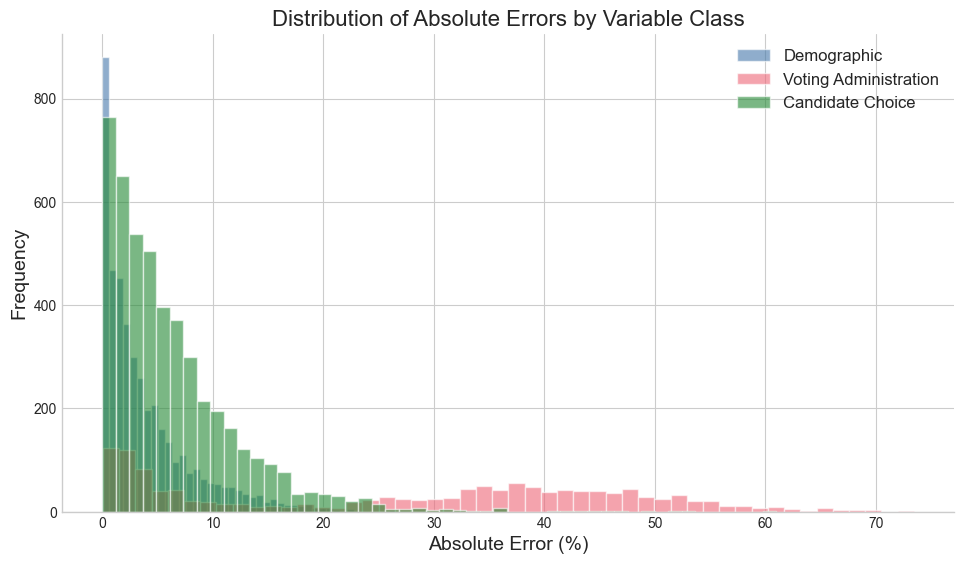

In [9]:
# Filter for CES-Weighted
df_hist = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

fig, ax = plt.subplots(figsize=(10, 6))

for cls in class_order:
    cls_data = df_hist[df_hist['Class'] == cls]['Error'].abs()
    ax.hist(cls_data, bins=50, alpha=0.6, label=cls, color=CLASS_COLORS[cls], edgecolor='white')

ax.set_xlabel('Absolute Error (%)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Distribution of Absolute Errors by Variable Class', fontsize=16)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

save_figure(fig, 'error_distribution_by_class.png')
plt.show()

---
# RMSE by Class Histogram

Saved: output/rmse_by_class_histogram.png


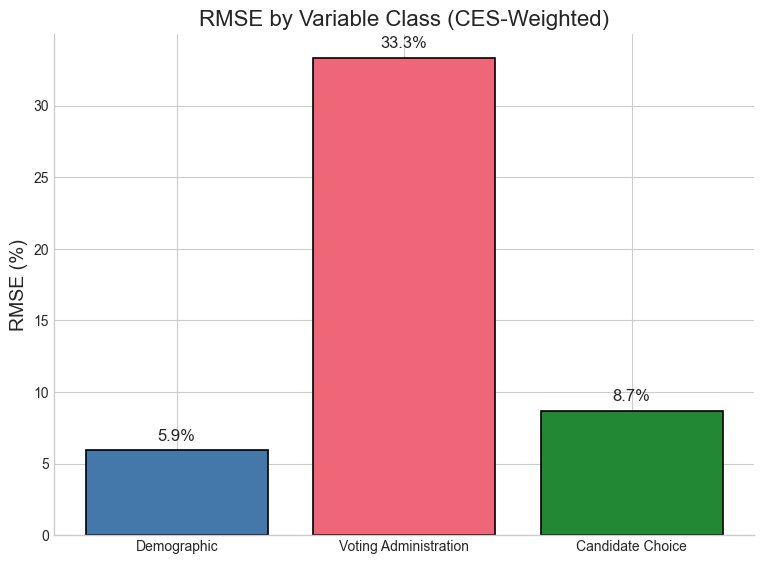

In [10]:
# Calculate RMSE by class
rmse_by_class = df_hist.groupby('Class').apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
).reindex(class_order)

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(rmse_by_class.index, rmse_by_class.values, 
              color=[CLASS_COLORS[c] for c in rmse_by_class.index],
              edgecolor='black', linewidth=1.2)

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('RMSE by Variable Class (CES-Weighted)', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for bar, val in zip(bars, rmse_by_class.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12)

save_figure(fig, 'rmse_by_class_histogram.png')
plt.show()

---
# Primary vs Secondary Comparison

Saved: output/rmse_primary_vs_secondary_comparison.png


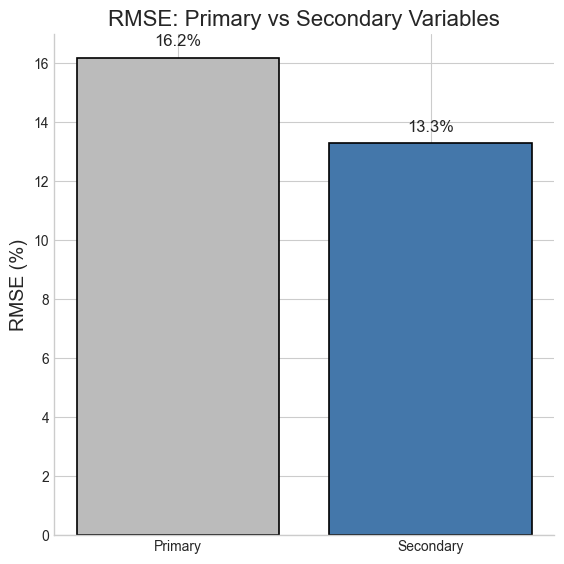

In [11]:
# Calculate RMSE by variable type
rmse_by_type = df_hist.groupby('Variable_Type').apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
)

fig, ax = plt.subplots(figsize=(6, 6))
types = ['Primary', 'Secondary']
values = [rmse_by_type.get(t, 0) for t in types]
colors = [VARIABLE_TYPE_COLORS[t] for t in types]

bars = ax.bar(types, values, color=colors, edgecolor='black', linewidth=1.2)

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('RMSE: Primary vs Secondary Variables', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12)

save_figure(fig, 'rmse_primary_vs_secondary_comparison.png')
plt.show()

---
# Primary vs Secondary by Year (Stacked Comparison)

Two-panel comparison:
- Top: All variables
- Bottom: Excluding Voter Registration and Voting Turnout

Saved: output/primary_vs_secondary_by_year_stacked.png


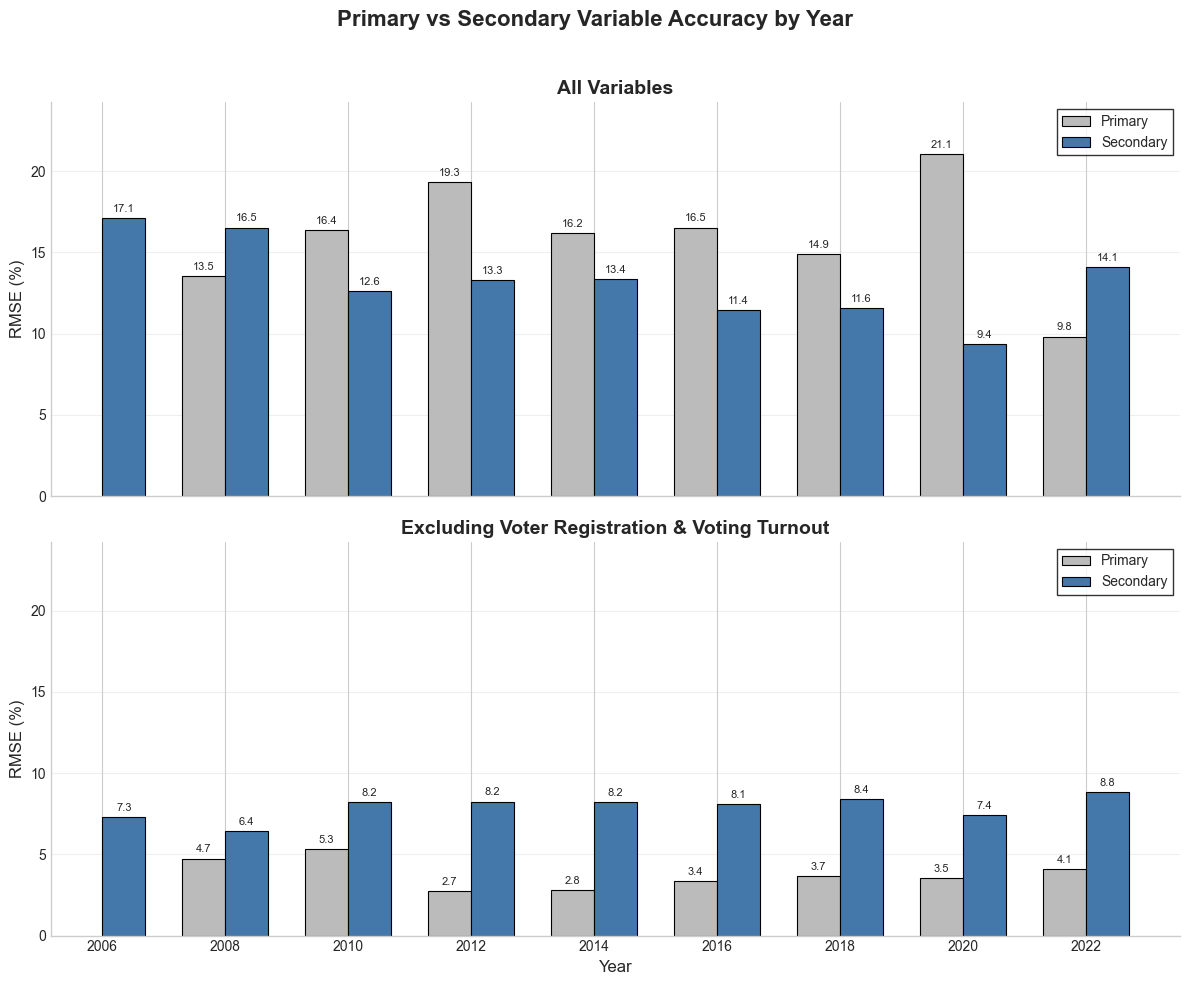


SUMMARY: Primary vs Secondary RMSE by Year

All Variables:
Variable_Type  Primary  Secondary
Year                             
2006               NaN       17.1
2008              13.5       16.5
2010              16.4       12.6
2012              19.3       13.3
2014              16.2       13.4
2016              16.5       11.4
2018              14.9       11.6
2020              21.1        9.4
2022               9.8       14.1

Overall Primary Mean: 16.0
Overall Secondary Mean: 13.3

Excluding Voter Registration & Voting Turnout:
Variable_Type  Primary  Secondary
Year                             
2006               NaN        7.3
2008               4.7        6.4
2010               5.3        8.2
2012               2.7        8.2
2014               2.8        8.2
2016               3.4        8.1
2018               3.7        8.4
2020               3.5        7.4
2022               4.1        8.8

Filtered Primary Mean: 3.8
Filtered Secondary Mean: 7.9


In [12]:
# =============================================================================
# PRIMARY VS SECONDARY BY YEAR - STACKED COMPARISON
# Top: All variables | Bottom: Excluding Voter Registration & Voting Turnout
# =============================================================================

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

years = sorted(df_ces['Year'].unique())

# Calculate RMSE by Year and Variable Type - ALL variables
rmse_all = df_ces.groupby(['Year', 'Variable_Type']).apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
).reset_index(name='RMSE')
rmse_all_pivot = rmse_all.pivot(index='Year', columns='Variable_Type', values='RMSE')

# Calculate RMSE by Year and Variable Type - EXCLUDING voter registration & turnout
exclude_vars = ['Voter Registration', 'Voting Turnout']
df_ces_filtered = df_ces[~df_ces['Variable'].isin(exclude_vars)]

rmse_filtered = df_ces_filtered.groupby(['Year', 'Variable_Type']).apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
).reset_index(name='RMSE')
rmse_filtered_pivot = rmse_filtered.pivot(index='Year', columns='Variable_Type', values='RMSE')

# Create stacked figure
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

x = np.arange(len(years))
width = 0.35

# Top panel: All variables
bars1_top = ax1.bar(x - width/2, rmse_all_pivot['Primary'], width, 
                    label='Primary', color=VARIABLE_TYPE_COLORS['Primary'], 
                    edgecolor='black', linewidth=0.8)
bars2_top = ax1.bar(x + width/2, rmse_all_pivot['Secondary'], width,
                    label='Secondary', color=VARIABLE_TYPE_COLORS['Secondary'],
                    edgecolor='black', linewidth=0.8)

ax1.set_ylabel('RMSE (%)', fontsize=12)
ax1.set_title('All Variables', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(0, max(rmse_all_pivot.max().max(), rmse_filtered_pivot.max().max()) * 1.15)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

# Add value labels
for bar in bars1_top:
    height = bar.get_height()
    if not np.isnan(height):
        ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2_top:
    height = bar.get_height()
    if not np.isnan(height):
        ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Bottom panel: Excluding voter registration & turnout
bars1_bot = ax2.bar(x - width/2, rmse_filtered_pivot['Primary'], width,
                    label='Primary', color=VARIABLE_TYPE_COLORS['Primary'],
                    edgecolor='black', linewidth=0.8)
bars2_bot = ax2.bar(x + width/2, rmse_filtered_pivot['Secondary'], width,
                    label='Secondary', color=VARIABLE_TYPE_COLORS['Secondary'],
                    edgecolor='black', linewidth=0.8)

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('RMSE (%)', fontsize=12)
ax2.set_title('Excluding Voter Registration & Voting Turnout', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, max(rmse_all_pivot.max().max(), rmse_filtered_pivot.max().max()) * 1.15)
ax2.grid(axis='y', linestyle='-', alpha=0.3)

# Add value labels
for bar in bars1_bot:
    height = bar.get_height()
    if not np.isnan(height):
        ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2_bot:
    height = bar.get_height()
    if not np.isnan(height):
        ax2.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

ax2.set_xticks(x)
ax2.set_xticklabels(years)

fig.suptitle('Primary vs Secondary Variable Accuracy by Year', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])

save_figure(fig, 'primary_vs_secondary_by_year_stacked.png', tight=False)
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY: Primary vs Secondary RMSE by Year")
print("="*70)
print("\nAll Variables:")
print(rmse_all_pivot.round(1).to_string())
print(f"\nOverall Primary Mean: {rmse_all_pivot['Primary'].mean():.1f}")
print(f"Overall Secondary Mean: {rmse_all_pivot['Secondary'].mean():.1f}")

print("\nExcluding Voter Registration & Voting Turnout:")
print(rmse_filtered_pivot.round(1).to_string())
print(f"\nFiltered Primary Mean: {rmse_filtered_pivot['Primary'].mean():.1f}")
print(f"Filtered Secondary Mean: {rmse_filtered_pivot['Secondary'].mean():.1f}")

---
# Error Trends Over Time

Saved: output/error_trends_over_time.png


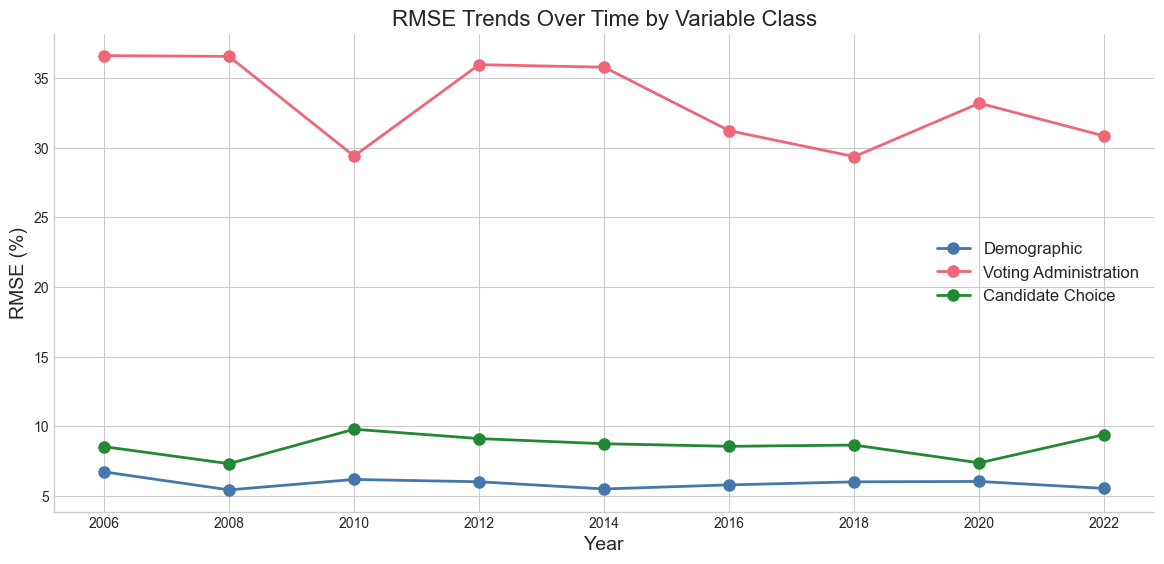

In [13]:
# Calculate RMSE by year and class
rmse_trends = df_hist.groupby(['Year', 'Class']).apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
).reset_index(name='RMSE')

fig, ax = plt.subplots(figsize=(12, 6))

for cls in class_order:
    cls_data = rmse_trends[rmse_trends['Class'] == cls]
    ax.plot(cls_data['Year'], cls_data['RMSE'], marker='o', linewidth=2,
            label=cls, color=CLASS_COLORS[cls], markersize=8)

ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('RMSE Trends Over Time by Variable Class', fontsize=16)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(sorted(rmse_trends['Year'].unique()))

save_figure(fig, 'error_trends_over_time.png')
plt.show()

---
# RMSE Trends for Always-Secondary Variables

Analysis of variables that are secondary in ALL years AND present in every survey year.
Includes linear regression trend lines with p-values to test for significant changes over time.

Always-secondary variables present in all years (8):
  - State Representative (Candidate Choice)
  - State Senator (Candidate Choice)
  - U.S. House (Candidate Choice)
  - Employment Status (Demographic)
  - Family Income (Demographic)
  - Union Membership (Demographic)
  - Veteran Status (Demographic)
  - Voting Method (Voting Administration)

RMSE by Class and Year:
Class  All  Candidate Choice  Demographic  Voting Administration
Year                                                            
2006   6.2               7.9          5.5                    3.7
2008   7.0               8.2          6.1                    4.3
2010   8.5              10.2          6.8                    6.0
2012   8.8               9.4          7.9                    4.5
2014   8.5               9.3          7.0                    3.4
2016   8.6               9.3          7.3                    5.4
2018   8.7               9.4          7.4                    5.0
2020   7.9               8.0          7.9   

Saved: output/rmse_trends_always_secondary.png


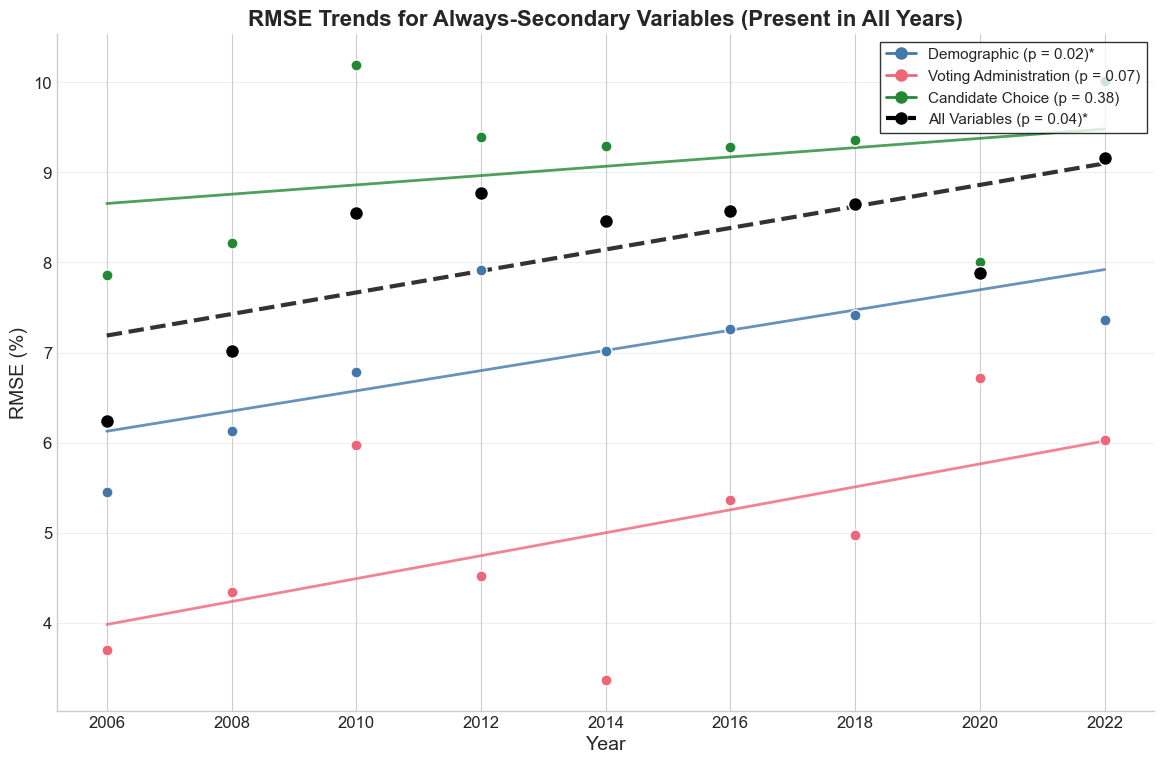

In [14]:
# =============================================================================
# RMSE TRENDS FOR ALWAYS-SECONDARY VARIABLES (PRESENT IN ALL YEARS)
# Variables that are Secondary in ALL years AND present in every survey year
# =============================================================================

# Get all years in the dataset
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())

# Identify always-secondary variables that are PRESENT IN ALL YEARS
always_secondary_all_years = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        always_secondary_all_years.append(var)

print(f"Always-secondary variables present in all years ({len(always_secondary_all_years)}):")
for v in always_secondary_all_years:
    cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
    print(f"  - {v} ({cls})")

# Filter to these variables only
df_secondary = df_ces[df_ces['Variable'].isin(always_secondary_all_years)].copy()

# Calculate RMSE by Year and Class
rmse_by_class_year = df_secondary.groupby(['Year', 'Class']).apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
).reset_index(name='RMSE')

# Calculate overall RMSE by Year (all classes combined)
rmse_all_year = df_secondary.groupby('Year').apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
).reset_index(name='RMSE')
rmse_all_year['Class'] = 'All'

# Combine
rmse_combined = pd.concat([rmse_by_class_year, rmse_all_year], ignore_index=True)

print("\nRMSE by Class and Year:")
print(rmse_combined.pivot(index='Year', columns='Class', values='RMSE').round(1).to_string())

# Color scheme with All
colors_with_all = {**CLASS_COLORS, 'All': '#000000'}

# Create plot
fig, ax = plt.subplots(figsize=(12, 8))

years = sorted(df_secondary['Year'].unique())
classes = ['Demographic', 'Voting Administration', 'Candidate Choice', 'All']

# Store regression results for legend
legend_entries = []

print("\n" + "="*60)
print("REGRESSION RESULTS")
print("="*60)

for cls in classes:
    cls_data = rmse_combined[rmse_combined['Class'] == cls].sort_values('Year')
    
    if len(cls_data) < 2:
        continue
    
    x = cls_data['Year'].values
    y = cls_data['RMSE'].values
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    # Format p-value for legend
    if p_value < 0.001:
        p_str = 'p < 0.001'
    elif p_value < 0.01:
        p_str = f'p = {p_value:.3f}'
    else:
        p_str = f'p = {p_value:.2f}'
    
    # Significance marker
    if p_value < 0.001:
        sig = '***'
    elif p_value < 0.01:
        sig = '**'
    elif p_value < 0.05:
        sig = '*'
    else:
        sig = ''
    
    color = colors_with_all[cls]
    linewidth = 3 if cls == 'All' else 2
    markersize = 10 if cls == 'All' else 8
    linestyle = '-' if cls != 'All' else '--'
    
    # Plot data points
    ax.scatter(x, y, color=color, s=markersize**2, zorder=5, edgecolors='white', linewidth=1)
    
    # Plot regression line
    x_line = np.array([min(years), max(years)])
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, color=color, linewidth=linewidth, linestyle=linestyle, alpha=0.8)
    
    # Legend label with p-value
    if cls == 'All':
        label = f'All Variables ({p_str}){sig}'
    else:
        label = f'{cls} ({p_str}){sig}'
    
    legend_entries.append((plt.Line2D([0], [0], color=color, linewidth=linewidth, 
                                       linestyle=linestyle, marker='o', markersize=8), label))
    
    print(f"\n{cls}:")
    print(f"  Slope: {slope:.3f} RMSE/year")
    print(f"  p-value: {p_value:.4f} {sig}")
    print(f"  R²: {r_value**2:.3f}")

# Styling
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('RMSE Trends for Always-Secondary Variables (Present in All Years)', fontsize=16, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(years)
ax.set_xticklabels(years, rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.grid(axis='y', linestyle='-', alpha=0.3)

# Custom legend
lines, labels = zip(*legend_entries)
ax.legend(lines, labels, loc='upper right', fontsize=11, frameon=True, 
          fancybox=False, edgecolor='black')

save_figure(fig, 'rmse_trends_always_secondary.png')
plt.show()

---
# Weighting Method Comparison: Error Reduction

Saved: output/error_reduction_ces_weights_by_type.png


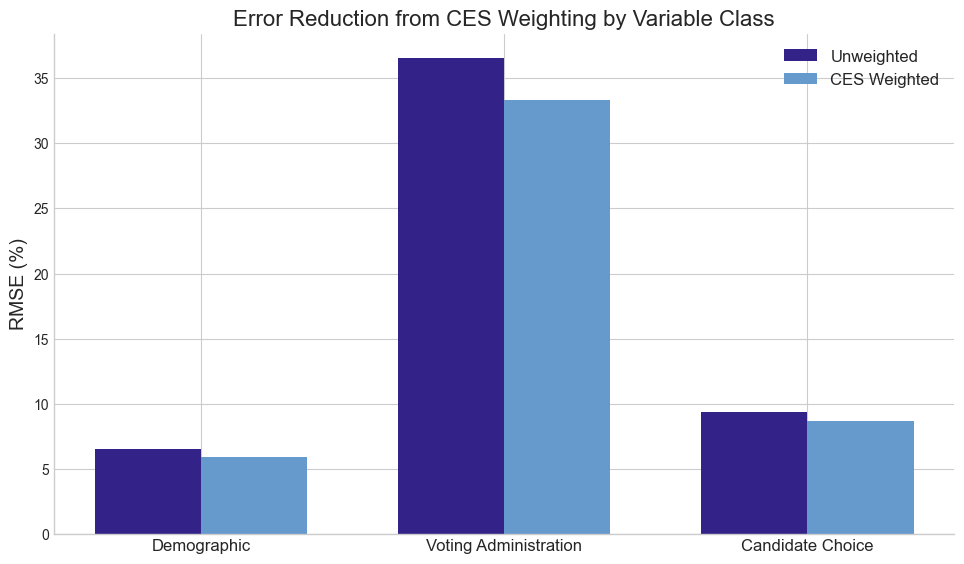


Error Reduction Summary:
Weighting_Method       CES-Unweighted  CES-Provided Weights  Reduction  \
Class                                                                    
Demographic                      6.52                  5.91       0.60   
Voting Administration           36.57                 33.33       3.24   
Candidate Choice                 9.37                  8.67       0.70   

Weighting_Method       Reduction_Pct  
Class                                 
Demographic                     9.25  
Voting Administration           8.86  
Candidate Choice                7.46  


In [15]:
# Calculate RMSE by weighting method and class
df_compare = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

rmse_by_method_class = df_compare.groupby(['Weighting_Method', 'Class']).apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
).reset_index(name='RMSE')

# Pivot for comparison
method_pivot = rmse_by_method_class.pivot(index='Class', columns='Weighting_Method', values='RMSE')
method_pivot = method_pivot.reindex(class_order)

# Calculate reduction from unweighted to CES-weighted
method_pivot['Reduction'] = method_pivot['CES-Unweighted'] - method_pivot['CES-Provided Weights']
method_pivot['Reduction_Pct'] = (method_pivot['Reduction'] / method_pivot['CES-Unweighted']) * 100

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_order))
width = 0.35

bars1 = ax.bar(x - width/2, method_pivot['CES-Unweighted'], width, 
               label='Unweighted', color=WEIGHTING_COLORS['CES-Unweighted'])
bars2 = ax.bar(x + width/2, method_pivot['CES-Provided Weights'], width,
               label='CES Weighted', color=WEIGHTING_COLORS['CES-Provided Weights'])

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Error Reduction from CES Weighting by Variable Class', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(class_order, fontsize=12)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

save_figure(fig, 'error_reduction_ces_weights_by_type.png')
plt.show()

print("\nError Reduction Summary:")
print(method_pivot[['CES-Unweighted', 'CES-Provided Weights', 'Reduction', 'Reduction_Pct']].round(2))

---
# ANESRake Full vs Restricted Comparison

Saved: output/anesrake_full_vs_restricted_comparison.png


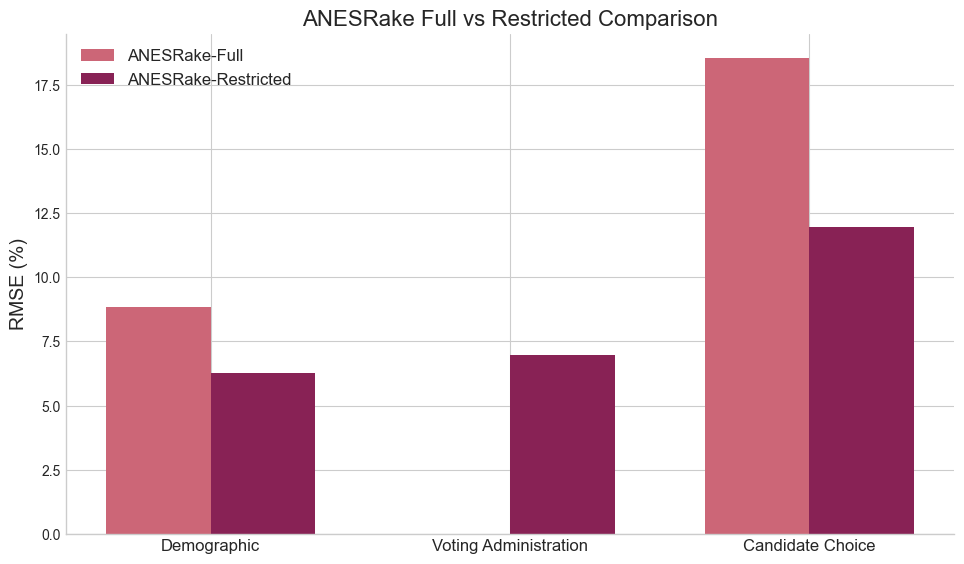


Saved: output/anesrake_full_vs_restricted_comparison.xlsx


In [16]:
# Compare ANESRake methods using appropriate validity schemes
df_anesrake_full = most_specific[
    (most_specific['Weighting_Method'] == 'ANESRake-Full') &
    (most_specific['Validity_Scheme'] == 'ANESRake - Full')
]

df_anesrake_restricted = most_specific[
    (most_specific['Weighting_Method'] == 'ANESRake-Restricted') &
    (most_specific['Validity_Scheme'] == 'ANESRake - Restricted')
]

rmse_full = df_anesrake_full.groupby('Class').apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
).reindex(class_order)

rmse_restricted = df_anesrake_restricted.groupby('Class').apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
).reindex(class_order)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(class_order))
width = 0.35

bars1 = ax.bar(x - width/2, rmse_full.values, width, 
               label='ANESRake-Full', color=WEIGHTING_COLORS['ANESRake-Full'])
bars2 = ax.bar(x + width/2, rmse_restricted.values, width,
               label='ANESRake-Restricted', color=WEIGHTING_COLORS['ANESRake-Restricted'])

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('ANESRake Full vs Restricted Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(class_order, fontsize=12)
ax.legend(fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

save_figure(fig, 'anesrake_full_vs_restricted_comparison.png')
plt.show()

# Save comparison data
comparison_df = pd.DataFrame({
    'Class': class_order,
    'ANESRake-Full': rmse_full.values,
    'ANESRake-Restricted': rmse_restricted.values
})
comparison_df.to_excel('output/anesrake_full_vs_restricted_comparison.xlsx', index=False)
print("\nSaved: output/anesrake_full_vs_restricted_comparison.xlsx")

---
# Candidate vs Party Specificity

Saved: output/candidate_vs_party_specificity.png


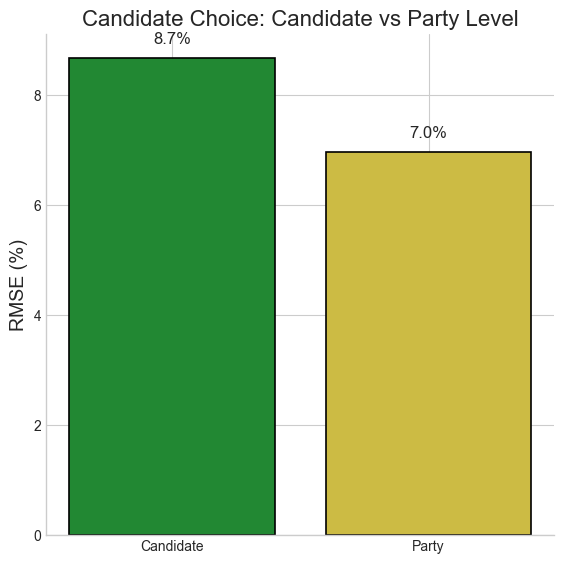

Saved: output/candidate_vs_party_specificity.xlsx


In [17]:
# Compare candidate vs party level for Candidate Choice variables
df_specificity = metrics_base_full[
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All') &
    (metrics_base_full['Class'] == 'Candidate Choice') &
    (metrics_base_full['Specificity'].notna())
].copy()

rmse_by_specificity = df_specificity.groupby('Specificity').apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
)

fig, ax = plt.subplots(figsize=(6, 6))
specificity_order = ['Candidate', 'Party']
values = [rmse_by_specificity.get(s, 0) for s in specificity_order]
colors = [SPECIFICITY_COLORS[s] for s in specificity_order]

bars = ax.bar(specificity_order, values, color=colors, edgecolor='black', linewidth=1.2)

ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Candidate Choice: Candidate vs Party Level', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=12)

save_figure(fig, 'candidate_vs_party_specificity.png')
plt.show()

# Save data and LaTeX
spec_df = pd.DataFrame({
    'Specificity': specificity_order,
    'RMSE': values
})
spec_df.to_excel('output/candidate_vs_party_specificity.xlsx', index=False)
print("Saved: output/candidate_vs_party_specificity.xlsx")

---
# RMSE by Office and Year Heatmap

Saved: output/rmse_by_office_year_heatmap.png


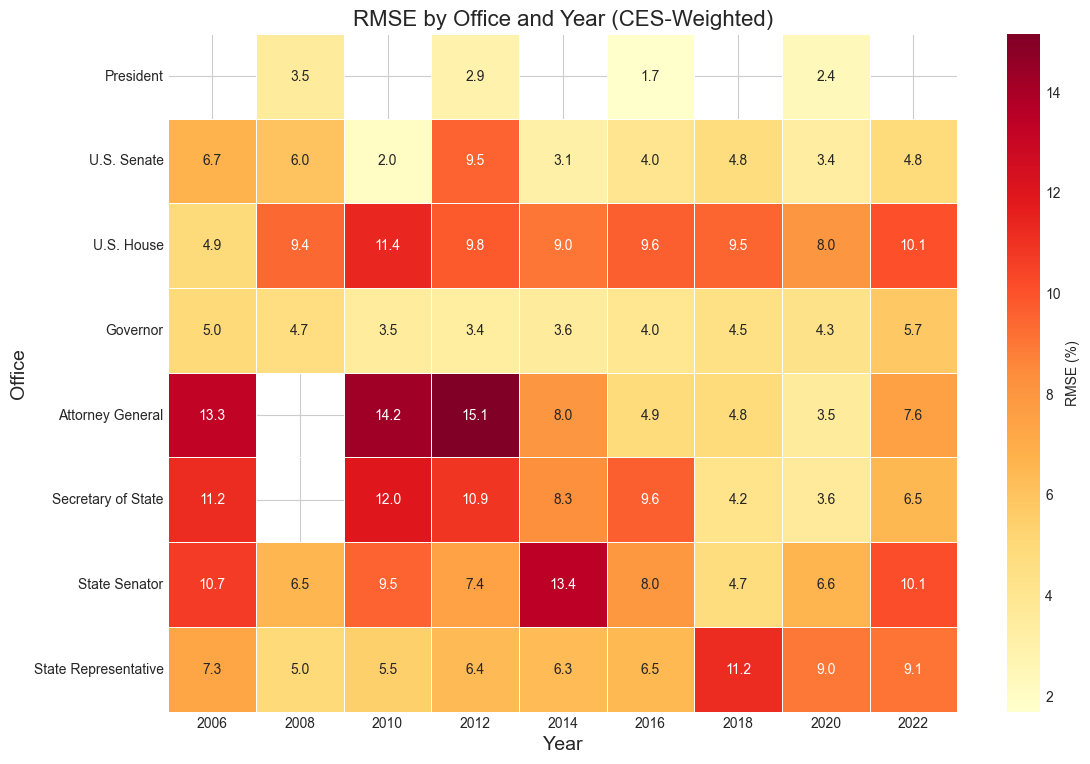

Saved: output/rmse_by_office_year.xlsx


In [18]:
# Filter for candidate choice only
df_offices = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Class'] == 'Candidate Choice')
].copy()

rmse_offices = df_offices.groupby(['Year', 'Variable']).apply(
    lambda x: calculate_rmse(x['Error']), include_groups=False
).reset_index(name='RMSE')

office_pivot = rmse_offices.pivot(index='Variable', columns='Year', values='RMSE')
office_pivot = sort_variables(office_pivot.reset_index()).set_index('Variable')

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(office_pivot, annot=True, fmt='.1f', cmap='YlOrRd', 
            linewidths=0.5, ax=ax, cbar_kws={'label': 'RMSE (%)'})
ax.set_title('RMSE by Office and Year (CES-Weighted)', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Office', fontsize=14)

save_figure(fig, 'rmse_by_office_year_heatmap.png')
plt.show()

# Save data
office_pivot.to_excel('output/rmse_by_office_year.xlsx')
print("Saved: output/rmse_by_office_year.xlsx")

---
# RMSE Excluding Voter Registration and Turnout

In [19]:
# ============================================================
# FIGURE 1A REPLICA: RMSE by Variable and Year
# (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)
# ============================================================

print("="*100)
print("FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)")
print("="*100)

# Filter for CES-Weighted, All validity, EXCLUDING the two high-error variables
df_excl = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (~most_specific['Variable'].isin(['Voter Registration', 'Voting Turnout']))
].copy()

print(f"\nTotal observations: {len(df_excl):,}")
print(f"Variables excluded: Voter Registration, Voting Turnout\n")

# Calculate RMSE by Year and Variable
rmse_by_var_year_excl = df_excl.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type for each cell
type_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

class_map_excl = rmse_by_var_year_excl.groupby('Variable')['Class'].first().to_dict()

rmse_pivot_excl = sort_variables(rmse_pivot_excl.reset_index()).set_index('Variable')
type_pivot_excl = sort_variables(type_pivot_excl.reset_index()).set_index('Variable')

years_excl = sorted([c for c in rmse_pivot_excl.columns if isinstance(c, (int, float))])

rmse_pivot_excl['Average'] = rmse_pivot_excl[years_excl].mean(axis=1)

avg_row_excl = rmse_pivot_excl.mean(axis=0)
avg_row_excl.name = 'Average'
rmse_pivot_with_avg_excl = pd.concat([rmse_pivot_excl, avg_row_excl.to_frame().T])

# Calculate class subtotals
class_values_excl = {cls: {year: [] for year in years_excl} for cls in class_order}
for var in rmse_pivot_excl.index:
    var_class = class_map_excl.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years_excl:
        val = rmse_pivot_excl.loc[var, year]
        if not pd.isna(val):
            class_values_excl[var_class][year].append(val)

class_subtotals_excl = {}
for cls in class_order:
    class_subtotals_excl[cls] = {}
    for year in years_excl:
        vals = class_values_excl[cls][year]
        class_subtotals_excl[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_excl[cls][y] for y in years_excl if not pd.isna(class_subtotals_excl[cls][y])]
    class_subtotals_excl[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Print formatted table
print("\n")
header = "{:<25}".format("Variable")
for year in years_excl:
    header += " {:>6}".format(str(int(year)))
header += " {:>12}".format("Yearly Mean")
print(header)
print("-" * len(header))

for cls in class_order:
    print(f"\n{cls}")
    
    for var in rmse_pivot_excl.index:
        var_class = class_map_excl.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row = "  {:<23}".format(var)
        for year in years_excl:
            val = rmse_pivot_excl.loc[var, year]
            if pd.isna(val):
                row += " {:>6}".format("-")
            else:
                var_type = type_pivot_excl.loc[var, year] if var in type_pivot_excl.index and year in type_pivot_excl.columns else None
                if var_type == 'Primary':
                    row += " {:>5}†".format(f"{val:.1f}")
                else:
                    row += " {:>6}".format(f"{val:.1f}")
        row_avg = rmse_pivot_with_avg_excl.loc[var, 'Average']
        if pd.isna(row_avg):
            row += " {:>12}".format("-")
        else:
            row += " {:>12}".format(f"{row_avg:.1f}")
        print(row)
    
    # Class average
    row = "  {:<23}".format(f"{cls} Avg.")
    for year in years_excl:
        val = class_subtotals_excl[cls][year]
        if pd.isna(val):
            row += " {:>6}".format("-")
        else:
            row += " {:>6}".format(f"{val:.1f}")
    row_avg = class_subtotals_excl[cls]['row_avg']
    if pd.isna(row_avg):
        row += " {:>12}".format("-")
    else:
        row += " {:>12}".format(f"{row_avg:.1f}")
    print(row)

# Yearly RMSE row
print("-" * len(header))
row = "{:<25}".format("Yearly RMSE")
yearly_rmse_values_excl = []
for year in years_excl:
    val = rmse_pivot_with_avg_excl.loc['Average', year]
    if pd.isna(val):
        row += " {:>6}".format("-")
    else:
        row += " {:>6}".format(f"{val:.1f}")
        yearly_rmse_values_excl.append(val)
annual_avg_excl = np.mean(yearly_rmse_values_excl) if yearly_rmse_values_excl else float('nan')
if pd.isna(annual_avg_excl):
    row += " {:>12}".format("-")
else:
    row += " {:>12}".format(f"{annual_avg_excl:.1f}")
print(row)

print("\n† indicates Primary variables (used in CES post-stratification weighting for that year)")

# Summary comparison
print("\n" + "="*80)
print("COMPARISON TO FIGURE 1 TABLE A (using mean-of-means approach)")
print("="*80)

# Calculate Figure 1 Table A approach for all variables
df_all = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
]
rmse_by_var_year_all = df_all.groupby(['Year', 'Variable']).apply(
    lambda x: calculate_rmse(x['Error']),
    include_groups=False
).reset_index(name='RMSE')
rmse_pivot_all = rmse_by_var_year_all.pivot_table(index='Variable', columns='Year', values='RMSE')
years_all = sorted([c for c in rmse_pivot_all.columns if isinstance(c, (int, float))])
avg_row_all = rmse_pivot_all.mean(axis=0)
annual_avg_all = np.mean([avg_row_all[y] for y in years_all])

print(f"\nWith all variables (Figure 1 Table A bottom-right):")
print(f"  Overall RMSE: {annual_avg_all:.1f}%")

print(f"\nExcluding Voter Registration & Voting Turnout:")
print(f"  Overall RMSE: {annual_avg_excl:.1f}%")

print(f"\nReduction: {annual_avg_all - annual_avg_excl:.1f} percentage points")
print(f"({((annual_avg_all - annual_avg_excl) / annual_avg_all * 100):.0f}% lower error)")

FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)

Total observations: 9,528
Variables excluded: Voter Registration, Voting Turnout



Variable                    2006   2008   2010   2012   2014   2016   2018   2020   2022  Yearly Mean
-----------------------------------------------------------------------------------------------------

Demographic
  Age Group                  6.9   3.3†   4.8†   2.8†   2.8†   2.6†   4.0†   4.7†   5.2†          4.1
  Education                 13.0   3.3†   6.1†   3.5†   3.9†   5.7†   4.4†   4.5†   3.8†          5.3
  Sex                        5.2   6.8†   5.0†   1.5†   2.0†   1.3†   2.9†   2.5†   3.1†          3.4
  Hispanic Origin              -      -    7.6    8.1    7.5    7.6    7.8    7.0    2.7          6.9
  Employment Status          7.0   10.3   10.6   13.5   11.5   12.0   12.2   12.4   10.1         11.1
  Family Income              4.5    3.5    3.9    3.9    4.4    4.9    5.3    6.8    8.8          5.1
  Union Membership

---
# Summary: Generated Files

In [20]:
import os

print("="*80)
print("GENERATED FILES SUMMARY")
print("="*80)

output_files = sorted(os.listdir('output'))
print(f"\nTotal files in output/: {len(output_files)}")
print("\nFiles:")
for f in output_files:
    size = os.path.getsize(f'output/{f}')
    print(f"  - {f} ({size:,} bytes)")

GENERATED FILES SUMMARY

Total files in output/: 19

Files:
  - .DS_Store (6,148 bytes)
  - anesrake_full_vs_restricted_comparison.png (125,753 bytes)
  - anesrake_full_vs_restricted_comparison.xlsx (5,108 bytes)
  - candidate_vs_party_specificity.png (74,612 bytes)
  - candidate_vs_party_specificity.xlsx (5,003 bytes)
  - error_distribution_by_class.png (141,448 bytes)
  - error_reduction_ces_weights_by_type.png (125,009 bytes)
  - error_trends_over_time.png (215,635 bytes)
  - primary_vs_secondary_by_year_stacked.png (229,983 bytes)
  - rmse_by_class_histogram.png (107,351 bytes)
  - rmse_by_office_year.xlsx (6,059 bytes)
  - rmse_by_office_year_heatmap.png (274,658 bytes)
  - rmse_ces_weighted_all.tex (4,851 bytes)
  - rmse_ces_weighted_by_type.tex (7,277 bytes)
  - rmse_primary_vs_secondary_comparison.png (81,071 bytes)
  - rmse_trends_always_secondary.png (287,881 bytes)
  - rmse_unweighted.tex (4,521 bytes)
  - us_house_cd_size_distribution.png (166,759 bytes)
  - us_house_error_

---
# Congressional District Size and U.S. House Accuracy

Analysis of how the number of CES respondents per congressional district affects U.S. House vote accuracy.

Total unique districts: 2839

Districts by bucket: {'0-50': np.int64(319), '50-100': np.int64(1682), '100-200': np.int64(835), '200-400': np.int64(3), '400-800': np.int64(0), '800+': np.int64(0)}

Average Absolute Error by bucket:
  0-50: 10.2% (n=319)
  50-100: 7.6% (n=1682)
  100-200: 5.9% (n=835)
  200-400: 3.9% (n=3)


Saved: output/us_house_error_by_cd_size.png


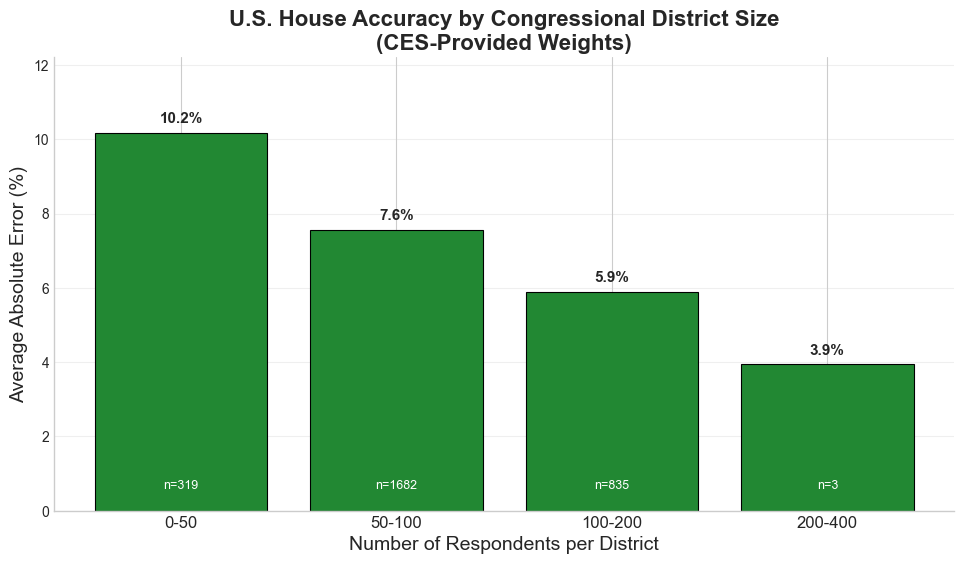

Saved: output/us_house_cd_size_distribution.png


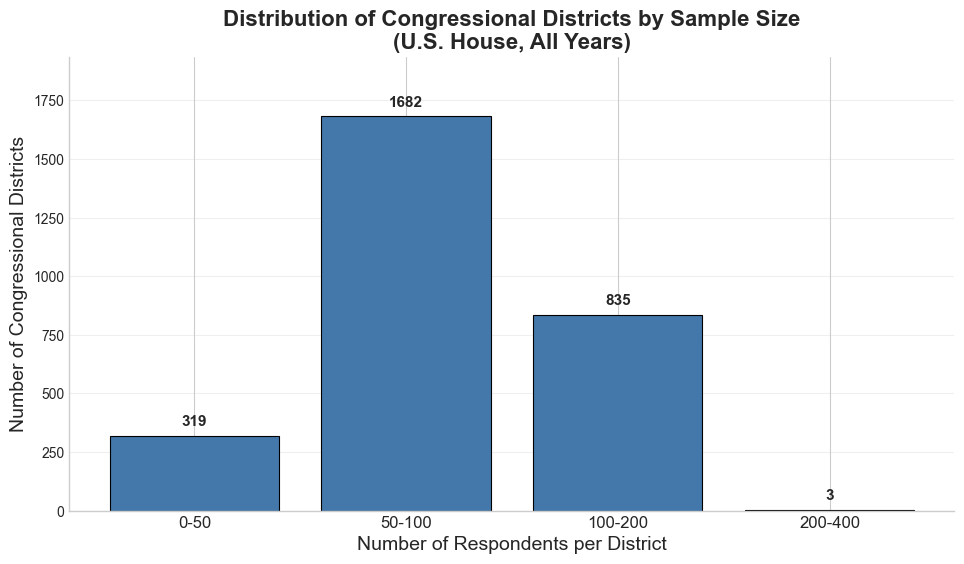


RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS

Year     All Districts      >100 respondents  
---------------------------------------------
2006            4.9%               4.3%
2008            8.6%               6.0%
2010           10.1%               6.2%
2012            9.3%               6.8%
2014            8.7%               6.2%
2016            9.2%               7.2%
2018            9.1%               5.6%
2020            7.7%               6.4%
2022            9.7%               7.3%
---------------------------------------------
Average         8.6%               6.2%

Districts: 2839 total, 809 with >100 respondents (28.5%)

Sentence: "If we had only measured error in CDs with >100 respondents,
the annual average RMSE for U.S. House would have gone from 8.6% to 6.2%."


In [21]:
# =============================================================================
# CONGRESSIONAL DISTRICT SIZE AND U.S. HOUSE ACCURACY
# =============================================================================

# Filter for U.S. House, CES-Provided Weights, Validity_Scheme='All'
df_house = metrics_base_full[
    (metrics_base_full['Variable'] == 'U.S. House') &
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All')
].copy()

# Create absolute error
df_house['Abs_Error'] = df_house['Error'].abs()

# Define buckets
def get_bucket(n):
    if n < 50:
        return '0-50'
    elif n < 100:
        return '50-100'
    elif n < 200:
        return '100-200'
    elif n < 400:
        return '200-400'
    elif n < 800:
        return '400-800'
    else:
        return '800+'

df_house['Respondent_Bucket'] = df_house['n_respondents'].apply(get_bucket)
bucket_order = ['0-50', '50-100', '100-200', '200-400', '400-800', '800+']

# Get unique district-level data
districts_df = df_house.groupby(['Year', 'State', 'District']).agg({
    'n_respondents': 'first',
    'Abs_Error': 'mean'
}).reset_index()
districts_df['Respondent_Bucket'] = districts_df['n_respondents'].apply(get_bucket)

# Calculate stats by bucket
district_counts = districts_df['Respondent_Bucket'].value_counts().reindex(bucket_order, fill_value=0)
avg_error_by_bucket = districts_df.groupby('Respondent_Bucket')['Abs_Error'].mean().reindex(bucket_order)

print(f"Total unique districts: {len(districts_df)}")
print(f"\nDistricts by bucket: {dict(district_counts)}")
print(f"\nAverage Absolute Error by bucket:")
for b in bucket_order:
    if district_counts[b] > 0:
        print(f"  {b}: {avg_error_by_bucket[b]:.1f}% (n={district_counts[b]})")

# ============================================================
# PLOT 1: Average Absolute Error by Respondent Bucket
# ============================================================
fig1, ax1 = plt.subplots(figsize=(10, 6))

valid_buckets = [b for b in bucket_order if district_counts[b] > 0]
x_pos = np.arange(len(valid_buckets))
values = [avg_error_by_bucket[b] for b in valid_buckets]
counts = [district_counts[b] for b in valid_buckets]

bars = ax1.bar(x_pos, values, color=CLASS_COLORS['Candidate Choice'], edgecolor='black', linewidth=0.8)

for i, (bar, val, n) in enumerate(zip(bars, values, counts)):
    ax1.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax1.annotate(f'n={n}', xy=(bar.get_x() + bar.get_width()/2, 0.5),
                ha='center', va='bottom', fontsize=9, color='white')

ax1.set_xlabel('Number of Respondents per District', fontsize=14)
ax1.set_ylabel('Average Absolute Error (%)', fontsize=14)
ax1.set_title('U.S. House Accuracy by Congressional District Size\n(CES-Provided Weights)', fontsize=16, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(valid_buckets, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(0, max(values) * 1.2)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig1, 'us_house_error_by_cd_size.png')
plt.show()

# ============================================================
# PLOT 2: Distribution of Districts by Respondent Bucket
# ============================================================
fig2, ax2 = plt.subplots(figsize=(10, 6))

bars2 = ax2.bar(x_pos, counts, color=CLASS_COLORS['Demographic'], edgecolor='black', linewidth=0.8)

for bar, n in zip(bars2, counts):
    ax2.annotate(f'{n}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('Number of Respondents per District', fontsize=14)
ax2.set_ylabel('Number of Congressional Districts', fontsize=14)
ax2.set_title('Distribution of Congressional Districts by Sample Size\n(U.S. House, All Years)', fontsize=16, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(valid_buckets, fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, max(counts) * 1.15)
ax2.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig2, 'us_house_cd_size_distribution.png')
plt.show()

# ============================================================
# RMSE Comparison: All Districts vs Large Districts
# ============================================================
print("\n" + "="*70)
print("RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS")
print("="*70)

rmse_all_by_year = df_house.groupby('Year')['Error'].apply(calculate_rmse)
df_100plus = df_house[df_house['n_respondents'] > 100]
rmse_100plus_by_year = df_100plus.groupby('Year')['Error'].apply(calculate_rmse)

print(f"\n{'Year':<8} {'All Districts':<18} {'>100 respondents':<18}")
print("-"*45)
for year in sorted(df_house['Year'].unique()):
    all_val = rmse_all_by_year.get(year, np.nan)
    plus100_val = rmse_100plus_by_year.get(year, np.nan)
    print(f"{year:<8} {all_val:>10.1f}%        {plus100_val:>10.1f}%")

avg_all = rmse_all_by_year.mean()
avg_100plus = rmse_100plus_by_year.mean()
print("-"*45)
print(f"{'Average':<8} {avg_all:>10.1f}%        {avg_100plus:>10.1f}%")

n_all = df_house.groupby(['Year', 'State', 'District']).ngroups
n_100plus = df_100plus.groupby(['Year', 'State', 'District']).ngroups
print(f"\nDistricts: {n_all} total, {n_100plus} with >100 respondents ({100*n_100plus/n_all:.1f}%)")
print(f"\nSentence: \"If we had only measured error in CDs with >100 respondents,")
print(f"the annual average RMSE for U.S. House would have gone from {avg_all:.1f}% to {avg_100plus:.1f}%.\"")
